In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet, LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    PolynomialFeatures,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
    QuantileTransformer,
)
from joblib import dump

from src.config import DADOS_LIMPOS, MODELO_FINAL
from src.auxiliares import dataframe_coeficientes
from src.graficos import (
    plot_coeficientes,
    plot_comparar_metricas_modelos,
    plot_residuos_estimador,
)
from src.models import (
    organiza_resultados,
    treinar_e_validar_modelo_regressao,
    grid_search_cv_regressor,
)

In [2]:
df = pd.read_parquet(DADOS_LIMPOS)

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room,population_per_room
0,-122.23,37.88,41,880,129,322,126,8.3252,452600,NEAR BAY,5,6.984127,2.555556,0.146591,0.365909
1,-122.22,37.86,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,5,6.238137,2.109842,0.155797,0.338217
2,-122.26,37.84,42,2555,665,1206,595,2.0804,226700,NEAR BAY,2,4.294118,2.026891,0.260274,0.472016
3,-122.26,37.85,50,1120,283,697,264,2.1250,140000,NEAR BAY,2,4.242424,2.640152,0.252679,0.622321
4,-122.26,37.84,50,2239,455,990,419,1.9911,158700,NEAR BAY,2,5.343675,2.362768,0.203216,0.442162


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17515 entries, 0 to 17514
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 17515 non-null  float64 
 1   latitude                  17515 non-null  float64 
 2   housing_median_age        17515 non-null  int8    
 3   total_rooms               17515 non-null  int16   
 4   total_bedrooms            17515 non-null  int16   
 5   population                17515 non-null  int16   
 6   households                17515 non-null  int16   
 7   median_income             17515 non-null  float64 
 8   median_house_value        17515 non-null  int32   
 9   ocean_proximity           17515 non-null  category
 10  median_income_cat         17515 non-null  int64   
 11  rooms_per_household       17515 non-null  float64 
 12  population_per_household  17515 non-null  float64 
 13  bedrooms_per_room         17515 non-null  floa

In [4]:
#Definir nossas colunas que serão preprocessadas
coluna_target = ['median_house_value']

coluna_one_hot_encoder = ['ocean_proximity']

coluna_ordinal_encoder = ['median_income_cat']

In [5]:
#Definir X e y
X = df.drop(columns = coluna_target)

y = df[coluna_target]

In [6]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room,population_per_room
0,-122.23,37.88,41,880,129,322,126,8.3252,NEAR BAY,5,6.984127,2.555556,0.146591,0.365909
1,-122.22,37.86,21,7099,1106,2401,1138,8.3014,NEAR BAY,5,6.238137,2.109842,0.155797,0.338217
2,-122.26,37.84,42,2555,665,1206,595,2.0804,NEAR BAY,2,4.294118,2.026891,0.260274,0.472016
3,-122.26,37.85,50,1120,283,697,264,2.1250,NEAR BAY,2,4.242424,2.640152,0.252679,0.622321
4,-122.26,37.84,50,2239,455,990,419,1.9911,NEAR BAY,2,5.343675,2.362768,0.203216,0.442162


In [7]:
y.head()

,median_house_value
0,452600
1,358500
2,226700
3,140000
4,158700


In [8]:
colunas_robust = df.columns.difference(coluna_target + coluna_one_hot_encoder + coluna_ordinal_encoder)
colunas_robust

Index(['bedrooms_per_room', 'households', 'housing_median_age', 'latitude',
       'longitude', 'median_income', 'population', 'population_per_household',
       'population_per_room', 'rooms_per_household', 'total_bedrooms',
       'total_rooms'],
      dtype='object')

In [9]:
colunas_standard = ["longitude","latitude","housing_median_age"]

colunas_power = df.columns.difference(coluna_target + coluna_one_hot_encoder + coluna_ordinal_encoder + colunas_standard)
colunas_power

Index(['bedrooms_per_room', 'households', 'median_income', 'population',
       'population_per_household', 'population_per_room',
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='object')

In [10]:
#criar o preprocessamento

pipeline_robust = Pipeline(steps=[
    ("robust_sacaler", RobustScaler()),
    ("poly", PolynomialFeatures(degree=1, include_bias=False))
])

preprocessamento = ColumnTransformer(
    transformers = [
        ("one_hot_encoder", OneHotEncoder(drop='first'),coluna_one_hot_encoder),
        ("ordinal_encoder", OrdinalEncoder(categories='auto'),coluna_ordinal_encoder),
        ("robust_scaler_poly", pipeline_robust, colunas_robust),
    ],
)


In [11]:
param_grid = {
    "regressor__preprocessor__robust_scaler_poly__poly__degree": [1, 2, 3],
    "regressor__reg__alpha":[1E-2,5E-2, 0.1, 0.25, 0.5, 1.0, 5, 10, 20],
}

In [12]:
grid_search = grid_search_cv_regressor(
    regressor=Ridge(alpha=1.0),
    param_grid=param_grid,
    preprocessor=preprocessamento,
    target_transformer=QuantileTransformer(output_distribution='normal'),
)

grid_search

,estimator,TransformedTa...ion='normal'))
,param_grid,"{'regressor__preprocesso...aler_poly__poly__degree': [1, 2, ...], 'regressor__reg__alpha': [0.01, 0.05, ...]}"
,scoring,"['r2', 'neg_mean_absolute_error', ...]"
,n_jobs,-1
,refit,'neg_root_mean_squared_error'
,cv,KFold(n_split... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('one_hot_encoder', ...), ('ordinal_encoder', ...), ...]"


In [13]:
grid_search.fit(X,y)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


,estimator,TransformedTa...ion='normal'))
,param_grid,"{'regressor__preprocesso...aler_poly__poly__degree': [1, 2, ...], 'regressor__reg__alpha': [0.01, 0.05, ...]}"
,scoring,"['r2', 'neg_mean_absolute_error', ...]"
,n_jobs,-1
,refit,'neg_root_mean_squared_error'
,cv,KFold(n_split... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('one_hot_encoder', ...), ('ordinal_encoder', ...), ...]"


In [14]:
grid_search.best_params_

{'regressor__preprocessor__robust_scaler_poly__poly__degree': 3,
 'regressor__reg__alpha': 10}

In [15]:
grid_search.best_score_

np.float64(-50429.20221947103)

In [16]:
grid_search.best_estimator_

,regressor,Pipeline(step...e(alpha=10))])
,transformer,QuantileTrans...tion='normal')
,func,None
,inverse_func,None
,check_inverse,True
,transformers,"[('one_hot_encoder', ...), ('ordinal_encoder', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False


In [17]:
grid_search.best_estimator_.regressor_

,steps,"[('preprocessor', ...), ('reg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('one_hot_encoder', ...), ('ordinal_encoder', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [18]:
# Definindo noss modelos de treino para comparação

regressors = {
    "DummyRegressor": {
        "preprocessor": None,
        "regressor": DummyRegressor(strategy="mean"),
        "target_transformer": None,
    },
    
    "LinearRegression": {
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": None,
    },
    "LinearRegression_target": {
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": QuantileTransformer(output_distribution='normal'),
    },
    
       "Ridge_grid_search": {
        "preprocessor": grid_search.best_estimator_.regressor_["preprocessor"],
        "regressor": grid_search.best_estimator_.regressor_["reg"],
        "target_transformer": grid_search.best_estimator_.transformer_,
    },
}

In [19]:
#Treinar e validar modelos

resultados = {
    nome_modelo: treinar_e_validar_modelo_regressao(X, y, **regressor)
    for nome_modelo, regressor in regressors.items()
}

resultados

{'DummyRegressor': {'fit_time': array([0.00510716, 0.00724125, 0.00625372, 0.0100956 , 0.00722909]),
  'score_time': array([0.00797009, 0.03020167, 0.01292062, 0.03666162, 0.01049447]),
  'test_r2': array([-8.79886502e-04, -7.01292589e-05, -3.90446967e-04, -1.07273469e-04,
         -1.34175423e-04]),
  'test_neg_mean_absolute_error': array([-76256.6430076 , -76449.68322658, -76241.74334592, -77052.4072976 ,
         -77839.12138232]),
  'test_neg_root_mean_squared_error': array([-95147.59926567, -96287.73388159, -95461.5544825 , -96172.37627931,
         -97119.54792537])},
 'LinearRegression': {'fit_time': array([0.05291772, 0.04175687, 0.03124714, 0.04687071, 0.04607987]),
  'score_time': array([0.01791668, 0.0112052 , 0.01562572, 0.02304721, 0.0156219 ]),
  'test_r2': array([0.69028914, 0.66606835, 0.66104148, 0.6679513 , 0.66398948]),
  'test_neg_mean_absolute_error': array([-39415.65518174, -40876.66288459, -41414.43293308, -40450.64599389,
         -41326.95514596]),
  'test_neg_

In [20]:
#dataframe comparativo com os resultados de tempo e erros dos modelos para cada 'cross-validation'
df_resultados = organiza_resultados(resultados)

df_resultados

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.005107,0.00797,-0.00088,-76256.643008,-95147.599266,0.013077
1,DummyRegressor,0.007241,0.030202,-0.00007,-76449.683227,-96287.733882,0.037443
2,DummyRegressor,0.006254,0.012921,-0.00039,-76241.743346,-95461.554483,0.019174
3,DummyRegressor,0.010096,0.036662,-0.000107,-77052.407298,-96172.376279,0.046757
4,DummyRegressor,0.007229,0.010494,-0.000134,-77839.121382,-97119.547925,0.017724
5,LinearRegression,0.052918,0.017917,0.690289,-39415.655182,-52927.949935,0.070834
6,LinearRegression,0.041757,0.011205,0.666068,-40876.662885,-55639.667647,0.052962
7,LinearRegression,0.031247,0.015626,0.661041,-41414.432933,-55567.007594,0.046873
8,LinearRegression,0.046871,0.023047,0.667951,-40450.645994,-55415.078057,0.069918
9,LinearRegression,0.04608,0.015622,0.663989,-41326.955146,-56292.942964,0.061702


In [21]:
#comparação das médias das métricas por modelo
df_resultados.groupby('model').mean().sort_values(by='test_neg_mean_absolute_error')

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.007185,0.01965,-0.000316,-76767.919652,-96037.762367,0.026835
LinearRegression,0.043774,0.016683,0.669868,-40696.870428,-55168.529239,0.060458
LinearRegression_target,0.064012,0.022438,0.679615,-38590.473697,-54342.590797,0.08645
Ridge_grid_search,0.268874,0.057007,0.724002,-35321.918353,-50436.49062,0.32588


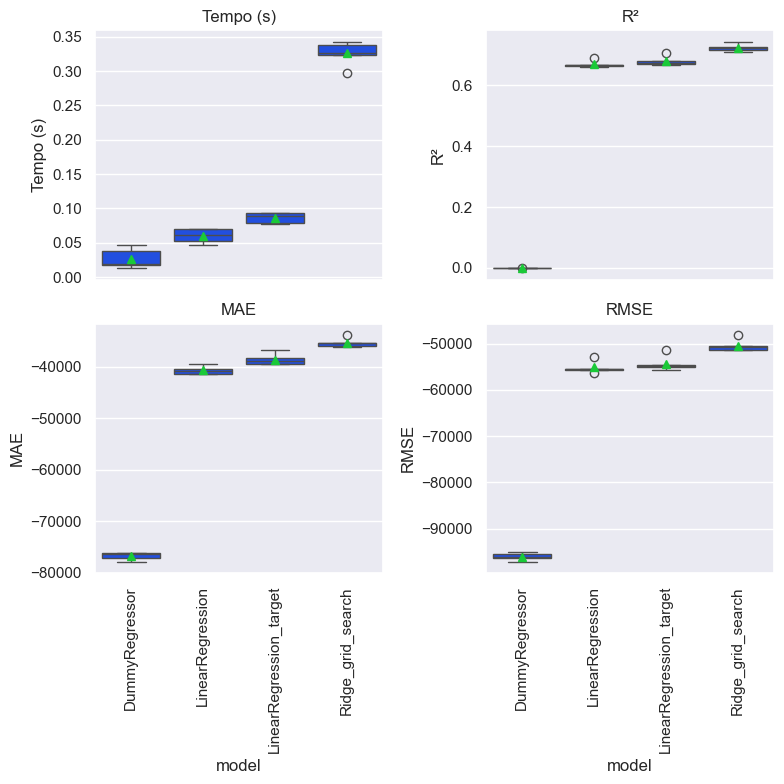

In [22]:
#gráfico comparativos das métricas de cada modelo
plot_comparar_metricas_modelos(df_resultados)

In [23]:
tempo_novo_anterior = df_resultados.groupby('model').mean()['time_seconds']['Ridge_grid_search'] / df_resultados.groupby('model').mean()['time_seconds']['LinearRegression_target']
tempo_novo_anterior

3.769598120221955

In [24]:
print(f'Adicionando um preprocessamento Polinomial de grau 3 em nossas colunas e alterando o modelo de regressão para o Ridge, obtivemos melhores resultado que o modelo mais simples, porém o tempo de treinamento desse modelo foi {tempo_novo_anterior:.0f}x maior que o modelo simples com Linear Regression e target transformer.')

Adicionando um preprocessamento Polinomial de grau 3 em nossas colunas e alterando o modelo de regressão para o Ridge, obtivemos melhores resultado que o modelo mais simples, porém o tempo de treinamento desse modelo foi 4x maior que o modelo simples com Linear Regression e target transformer.


In [25]:
#criando dataframe dos coeficientes
coefs = dataframe_coeficientes(
    grid_search.best_estimator_.regressor_["reg"].coef_,
    grid_search.best_estimator_.regressor_["preprocessor"].get_feature_names_out()
)

coefs

,coeficiente
robust_scaler_poly__longitude,-1.034549
robust_scaler_poly__latitude,-0.958716
one_hot_encoder__ocean_proximity_INLAND,-0.461583
robust_scaler_poly__latitude longitude population_per_household,-0.323442
robust_scaler_poly__latitude^2,-0.308857
...,...
robust_scaler_poly__latitude^3,0.218038
robust_scaler_poly__latitude^2 longitude,0.243666
robust_scaler_poly__housing_median_age median_income,0.259601
robust_scaler_poly__bedrooms_per_room,0.329176


In [26]:
coefs[coefs['coeficiente'] == 0]

,coeficiente


In [27]:
coefs[~coefs['coeficiente'].between(-0.25,0.25)]

,coeficiente
robust_scaler_poly__longitude,-1.034549
robust_scaler_poly__latitude,-0.958716
one_hot_encoder__ocean_proximity_INLAND,-0.461583
robust_scaler_poly__latitude longitude population_per_household,-0.323442
robust_scaler_poly__latitude^2,-0.308857
robust_scaler_poly__housing_median_age latitude,-0.297352
robust_scaler_poly__latitude longitude population_per_room,-0.255511
robust_scaler_poly__housing_median_age median_income,0.259601
robust_scaler_poly__bedrooms_per_room,0.329176
robust_scaler_poly__median_income,0.978198


In [28]:
coefs = coefs[~coefs['coeficiente'].between(-0.25,0.25)]
coefs

,coeficiente
robust_scaler_poly__longitude,-1.034549
robust_scaler_poly__latitude,-0.958716
one_hot_encoder__ocean_proximity_INLAND,-0.461583
robust_scaler_poly__latitude longitude population_per_household,-0.323442
robust_scaler_poly__latitude^2,-0.308857
robust_scaler_poly__housing_median_age latitude,-0.297352
robust_scaler_poly__latitude longitude population_per_room,-0.255511
robust_scaler_poly__housing_median_age median_income,0.259601
robust_scaler_poly__bedrooms_per_room,0.329176
robust_scaler_poly__median_income,0.978198


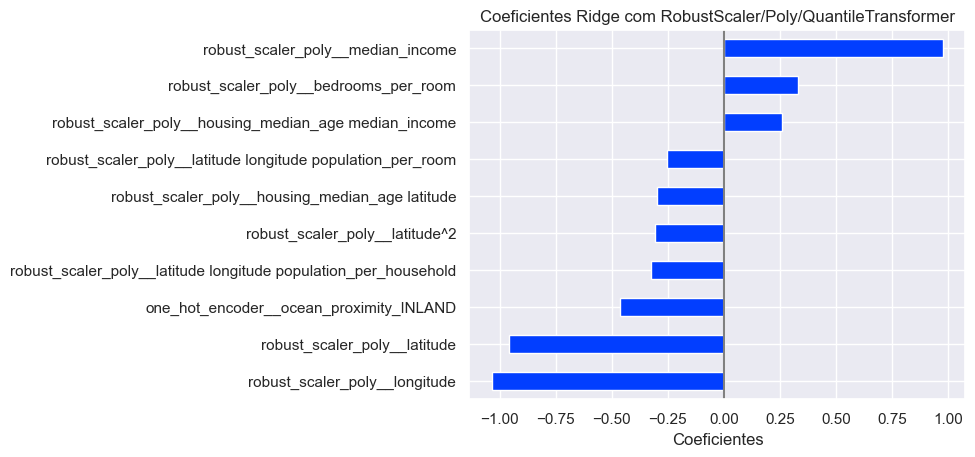

In [29]:
#analise gráfica dos coeficientes do melhor modelo
plot_coeficientes(
    coefs, 
    tituto="Coeficientes Ridge com RobustScaler/Poly/QuantileTransformer")

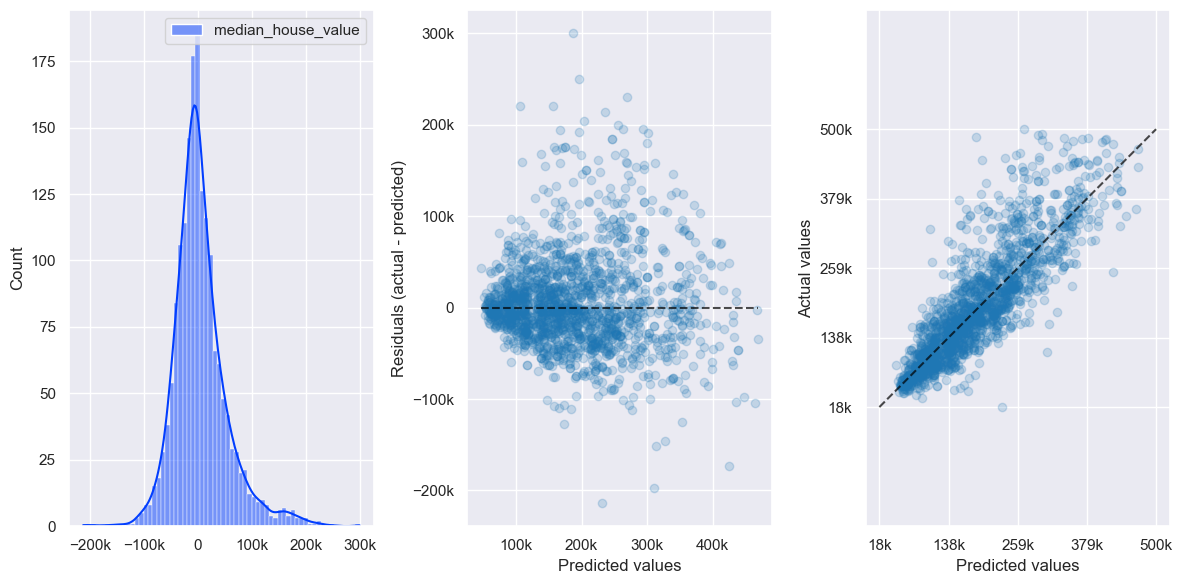

In [30]:
plot_residuos_estimador(
    grid_search.best_estimator_, 
    X, 
    y,
    fracao_amostra=0.1,
    eng_formatter=True
)

O gráfico de resíduos mostra que o Modelo consegue prever os valores medios das casas com pequeno erro para a maior parte dos valores. E o modelo tem mais erros para uma valor menor que o valor real. Visualmente não há grande diferenças no residuos em relação ao modelos anterior, essa comparação pode ser melhor vizualiada na tabela e graficos comparativa de erros feita anteriormente.

### Conclusão

O modelo feito neste notebook com o Ridge teve o melhor desempenho e com um tempo bom de processamento. Tivemos melhorias em relação ao modelo simples inicial referente ao erro médio que foi reduzido. Esse será o modelo escolhido para dar sequência ao projeto, porém podemos retornar a esse modelo mais tarde para avaliar e testar novas melhorias.

https://scikit-learn.org/stable/model_persistence.html

https://joblib.readthedocs.io/en/latest/persistence.html#use-case

In [31]:
#Salvando modelo na pasta /modelos

dump(grid_search.best_estimator_, MODELO_FINAL)

['C:\\Users\\gabri\\OneDrive\\Projetos_Analise_Dados\\California_housing_prices\\modelos\\ridge_polyfeat_target_quantile.joblib']